In [1]:
import xarray as xr
import grib2io
import pandas as pd
import datetime
from glob import glob
from tqdm.auto import tqdm
import numpy as np
import multiprocessing
import numba
import scipy
from netCDF4 import Dataset

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({
 "savefig.facecolor": "w",
 "figure.facecolor" : 'w',
 "figure.figsize" : (8,6),
 "text.color": "k",
 "legend.fontsize" : 20,
 "font.size" : 30,
 "axes.edgecolor": "k",
 "axes.labelcolor": "k",
 "axes.linewidth": 3,
 "xtick.color": "k",
 "ytick.color": "k",
 "xtick.labelsize" : 25,
 "ytick.labelsize" : 25,
 "ytick.major.size" : 12,
 "xtick.major.size" : 12,
 "ytick.major.width" : 2,
 "xtick.major.width" : 2,
 "font.family": 'STIXGeneral',
 "mathtext.fontset" : "cm"})

## utils

In [2]:
colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

In [5]:
from nimbl import stations  #.from_mos2ktbl

#selected stations for analysis
station_data = '//scratch1/NCEPDEV/mdl/Eric.Engle/gitrepos/blend/fix/common/mdl_station.tbl'
station_points = stations.from_mos2ktbl(station_data, ['KSEA','KMSP','KBOS', 'KLAS','KLIT','KMCO', 'KDEN', 'KCVG'])

#rename weird ones
st_names = station_points['name'].copy()
st_names[3] = 'Las Vegas'
st_names[6] = 'Denver'
st_names[8] = 'Cincinnati'

In [49]:
station_points

call link1               name state  elev      lat       lon  tz  \
0  KSEA   SEA     SEATTLE-TACOMA    WA   450  47.4500 -122.3000  -8   
1  KMSP   MSP        MINNEAPOLIS    MN   838  44.8833  -93.2167  -6   
2  KBOS   BOS             BOSTON    MA    29  42.3667  -71.0333  -5   
3  KLAS   LAS  LAS VEGAS    ASOS    NV  2180  36.0833 -115.1667  -8   
4  KLIT   LIT        LITTLE ROCK    AR   257  34.7333  -92.2333  -6   
5  KMCO   MCO       ORLANDO INTL    FL   105  28.4333  -81.3167  -5   
6  KDEN   DEN  DENVER INTL  ASOS    CO  5431  39.8466 -104.6562  -7   
7  KDEN   DEN   DENVER STAPLETON    CO  5332  39.7500 -104.8667  -7   
8  KCVG   CVG  COVINGTON    ASOS    KY   877  39.0500  -84.6667  -5   

                                             comment  
0     COMMISSIONED 10/01/96 NWRFC                ...  
1      COMMISSIONED 06/01/96 MBRFC               ...  
2      COMMISSIONED ASOS 4/1/96                  ...  
3      COMMISSIONED 9/1/95 CNRFC/CBRFC  RPT TIME-...  
4                                                ...  
5      COMMISSIONED 07/01/96                     ...  
6  DVX 2/94  CHNGD TO DEN 2/28/95 1ST SAO 8Z NMC ...  
7  CALL LETTERS REUSED LAST SAO 2/28/95 AT 07Z   ...  
8      COMMISSIONED 10/1/95                      ...

In [8]:
#random CONUS dataset to get lat/lon
ds = xr.open_dataset('/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2017/2017147.15.nc')
#unpack lats and lons to index over
lats = ds.latitude.data
lons = ds.longitude.data
ds.close()

ny, nx = np.shape(lats)

In [9]:
def get_nearest_grid(lat_input, long_input):
    # Get indices of the nearest lat/lon values
    # Lat/long input will be values corresponding to chosen stations
    lat_index, lon_index = [],[]


    for i in range(len(lat_input)):
        a = np.abs(lats-station_lats[i]) + np.abs(lons-station_lons[i])
        i,j = np.unravel_index(a.argmin(), a.shape)
        lat_index.append(i)
        lon_index.append(j)
    return lat_index, lon_index

def to360(x):
    return (x - 180) % 360 + 180

station_lats = station_points['lat']
station_lons = to360(station_points['lon']) #need to convert from E/W to 0-360

lat_idx, lon_idx = get_nearest_grid(station_lats, station_lons)

conus_gp = (lat_idx, lon_idx)

def find_nearest(array,value):
    idx = (np.abs(np.array(array)-value)).argmin()
    return idx

In [41]:
conus_gp

([1203, 994, 949, 646, 533, 281, 774, 770, 739],
 [414, 1347, 2098, 563, 1389, 1815, 952, 944, 1650])

# Diurnal cycle from 3 month window

## Determining time of peak rainfall over 24 hours

The goal of this analysis is to use the diurnal cycle of precipitation as an additional constraint for the supplemental locations algorithm. The idea is to compare rainfall patterns, measured from 3-hour totals, between the origin point and potential supplemental locations. This will provide additional information that can't be determined from the monthly precipitation distributions alone. 

Below is the prototype for characterizing the diurnal cycle at the stations of interest. I'll use Fourier analysis to decompose the precipitation data into their constituent periodic modes. From FFT, I can back out the most significant components that describe the periodic nature of the rainfall -- primarily the 24 hour cycle but we'll also see some locations that typically have more than 1 significant episode of rainfall a day. The property of interest (among several possible) is *when* the most rain tends to fall during a 24 hour period, which is measured from the phase shifts of the dominant modes of periodicty. 

Of course, this is not the only way to determine when rainfall peaks (an alternative would be to take the average rainfall in each hour from the stacked measurements over the 2002-2023 period, but the accuracy of that average amount seems to me like it would be low) but is one that is pretty commonly used when analyzing diurnal precipitation cycles in the literature.

## stack each day from all years (e.g., sum hour 0 for each July 1 from 2002-2023, etc.)

In [173]:
def open_and_sum(files):
    apcp_sums = np.zeros((len(st_names),8),dtype=np.float32)
    
    #sum given hour for each day/year
    for hour in range(8):
        for file in files[hour]:
            ds = Dataset(file, mode='r')
            apcp_var = ds.variables['precipitation']
            apcp = np.asarray(apcp_var[0])
            ds.close()
            apcp = np.where(apcp < 0.254, 0., apcp)
            apcp_sums[:, hour] += apcp[conus_gp[0], conus_gp[1]]
    return apcp_sums

In [174]:

month = 7
domain='co'
chosen_date = datetime.datetime(year=2023, month=month, day=1)
#logic for determining prev/next months
if month == 1:
    prev_month = 12
    next_month = month+1
elif month == 12:
    prev_month = month-1
    next_month = 1
else:
    prev_month = month-1
    next_month = month+1

start = datetime.datetime(year=2023, month=prev_month, day=1)
this_doy = start.strftime('%Y%j')
start = int(this_doy[4:])
end = start+90 #how does datetime not have a # of days in month func??

hours = np.arange(0,24,3)
num_hours=len(hours)
days = np.arange(start, end+1)
num_days = len(days)

def precip_by_day(doy):
    this_day_files = []
    for hour in range(num_hours):
        path = f"/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/{domain}/*/*{doy:03d}.{hours[hour]:02d}.nc"
        expected_files = sorted(glob(path))
        this_day_files.append(expected_files)
    precip = open_and_sum(this_day_files)
    return precip

In [175]:
n_processes = 30

print('Processing files, making daily sums')
start = datetime.datetime.now()
print(f'    Using {n_processes} CPUs')
with multiprocessing.Pool(n_processes) as P:
    out = P.map(precip_by_day, days)
out = np.asarray(out)
end=datetime.datetime.now()
print(f'    Finished in {(end-start).total_seconds()}s')
P.close()

Processing files, making daily sums
    Using 30 CPUs
    Finished in 115.427637s


Text(0.0485, 0.15, 'Relative Power at Period')

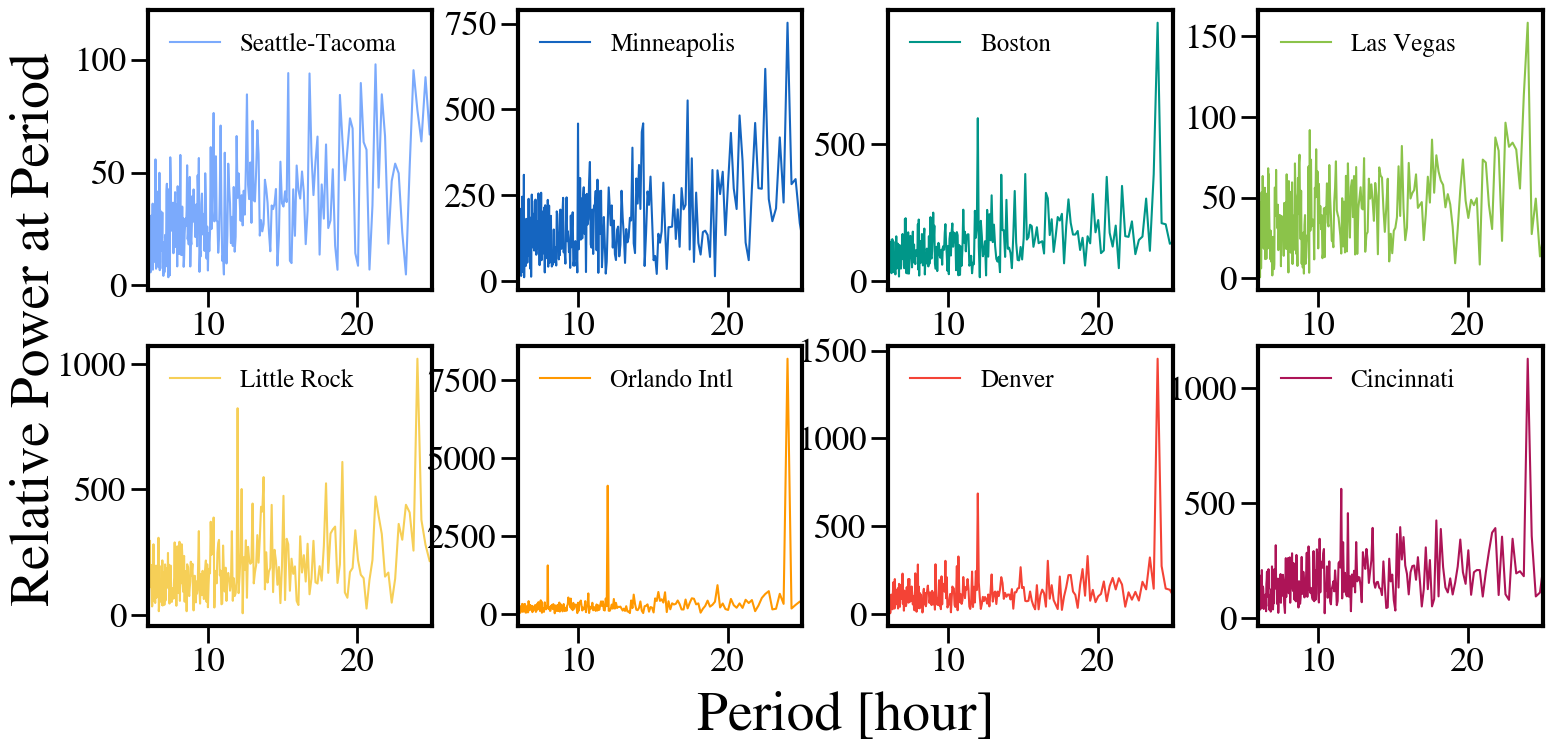

In [62]:
## All together

fig, axes = plt.subplots(2,4, figsize=(18, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.2)

colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

for i in range(2):
    for j in range(4):
        stat = 4*i+j
        if stat == 7:
            stat = 8
        precip_data = np.ravel(out[:,stat,:])

        #FFT
        fft_result = np.fft.fft(precip_data)
        frequencies = np.fft.fftfreq(len(precip_data), d=3)
        amplitude_spectrum = np.abs(fft_result)#/np.max(np.abs(fft_result))

        #to time
        time_lims = [6.,25.] #can't sample below twice the time resolution of data
        freq_lims = [find_nearest(frequencies,1./time_lims[1]), find_nearest(frequencies,1./time_lims[0])]
        trange = 1./frequencies[freq_lims[0]:freq_lims[1]]
        signal = np.abs(fft_result[freq_lims[0]:freq_lims[1]])#/np.max(np.abs(fft_result[freq_lims[0]:freq_lims[1]]))
        
        axes[i,j].plot(trange,signal, color=colors[stat],label=st_names[stat].title())
        #axes[i,j].fill_between(trange, np.std(signal), (np.mean(signal) + 5*np.std(signal)), color='gray', alpha=0.4, zorder=10)
        #axes[i,j].plot(time_lims, [np.mean(signal),np.mean(signal)], color='black', lw=2)
        axes[i,j].legend(frameon=False, fontsize=18, loc='upper left')
        axes[i,j].set_xlim(time_lims)
        #axes[i,j].set_ylim([0,1.2])

fig.text(x=0.43, y=-0.02, s='Period [hour]', fontdict={'fontsize': 40})
fig.text(x=0.0485, y=0.15, s='Relative Power at Period', rotation='vertical',fontdict={'fontsize': 40})

Sure.

Sticking with the Fourier analysis I think will be viable IF

- we can explain what the phase shift (= where peak of signal in time space occurs) means physically (i.e., is it time when most rain occurs or when rain is most frequent?)
  
- we devise a way to compare locations with and without strong diurnal signals (Orlando, Denver ; Seattle, Las Vegas)

0 = 1.3697146043757564
1 = -0.9767955594043022
2 = 1.3015730702227133
3 = 0.4049094582637371
4 = 1.1558487353878355
5 = 1.0415971717900772
6 = 0.20035865432827435
8 = 1.2183474649128714


Text(0.0485, 0.15, 'Stacked Precipitation [mm]')

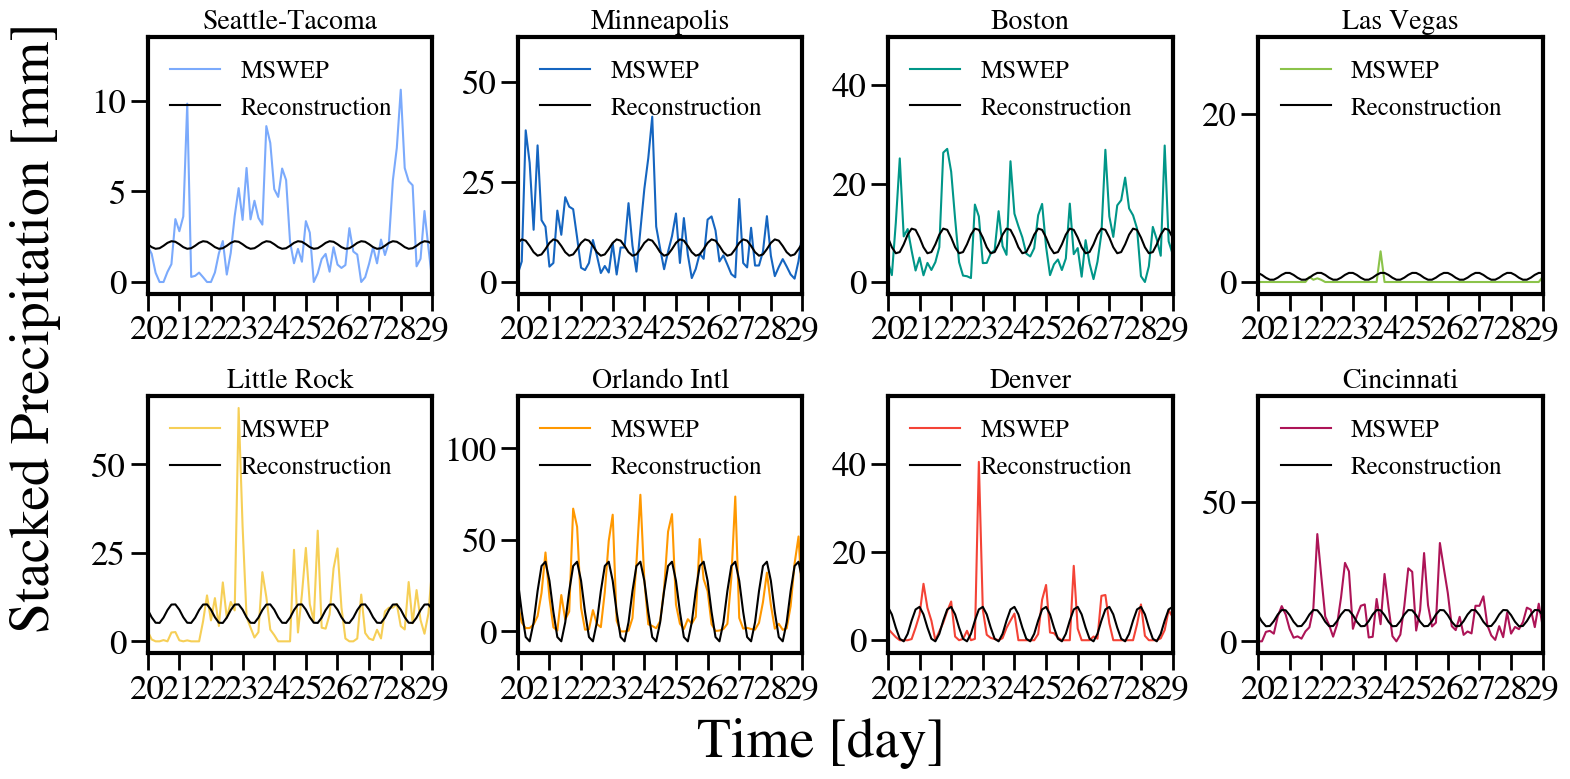

In [216]:
fig, axes = plt.subplots(2,4, figsize=(18, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

hours =np.arange(0, len(precip_data))

colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

time_of_peak = []

for i in range(2):
    for j in range(4):
        stat = 4*i+j
        if stat == 7:
            stat = 8
        precip_data = np.ravel(out[:,stat,:])

        #FFT
        fft_result = np.fft.fft(precip_data)
        frequencies = np.fft.fftfreq(len(precip_data), d=3)
        amplitude_spectrum = np.abs(fft_result)/np.max(np.abs(fft_result))

        #get diurnal
        target_frequency = 1. / 24.
        idx = find_nearest(frequencies, target_frequency)
        fft_filtered = np.zeros_like(fft_result)
        fft_filtered[idx] = fft_result[idx]
        fft_filtered[-idx] = fft_result[-idx]

        phase = np.angle(fft_result[idx])
        print(f"{stat} = {phase}")
        # Calculate the time of peak precipitation within a 24-hour period
        # Phase shift (in hours) = (phase / (2 * pi)) * 24
        tt = (phase / (2 * np.pi)) * 24
        if tt < 0:
            tt = 24 + tt
        time_of_peak.append(tt)
        #time_of_peak.append(24 * np.arctan(-1*fft_result[idx].imag/fft_result[idx].real) % 24)
        
        # Inverse FFT to get the reconstructed signal
        reconstructed_signal = np.fft.ifft(fft_filtered)

        #format ticks
        d = np.arange(20,30)
        axes[i,j].set_xlim([d[0]*8, d[-1]*8])
        axes[i,j].set_xticks(d*8,[x for x in d])

        #plot
        axes[i,j].plot(hours, precip_data, color=colors[stat],label='MSWEP')
        axes[i,j].plot(hours, reconstructed_signal.real + np.mean(precip_data), color='black', label='Reconstruction')
        axes[i,j].set_title(st_names[stat].title(), fontsize=20)
        axes[i,j].legend(frameon=False, fontsize=18, loc='upper left')
    
fig.text(x=0.43, y=-0.02, s='Time [day]', fontdict={'fontsize': 40})
fig.text(x=0.0485, y=0.15, s='Stacked Precipitation [mm]', rotation='vertical',fontdict={'fontsize': 40})
        

In [219]:
time_of_peak

[5.231924397877475,
 20.268915799934213,
 4.971642910109746,
 1.5466402028960462,
 4.4150169528837635,
 3.9786081264222926,
 0.7653136854620456,
 4.653744514664712]

In [220]:
(time_of_peak[5] + 2*5) - 12

1.9786081264222926

In [205]:
stat = 0
tt = (time_of_peak[stat] + 2*np.abs(station_points['tz'][stat]))

21.231924397877474

In [196]:
24 - np.abs(5.23 - 8) - 12

9.23

In [133]:
station_points

call link1               name state  elev      lat       lon  tz  \
0  KSEA   SEA     SEATTLE-TACOMA    WA   450  47.4500 -122.3000  -8   
1  KMSP   MSP        MINNEAPOLIS    MN   838  44.8833  -93.2167  -6   
2  KBOS   BOS             BOSTON    MA    29  42.3667  -71.0333  -5   
3  KLAS   LAS  LAS VEGAS    ASOS    NV  2180  36.0833 -115.1667  -8   
4  KLIT   LIT        LITTLE ROCK    AR   257  34.7333  -92.2333  -6   
5  KMCO   MCO       ORLANDO INTL    FL   105  28.4333  -81.3167  -5   
6  KDEN   DEN  DENVER INTL  ASOS    CO  5431  39.8466 -104.6562  -7   
7  KDEN   DEN   DENVER STAPLETON    CO  5332  39.7500 -104.8667  -7   
8  KCVG   CVG  COVINGTON    ASOS    KY   877  39.0500  -84.6667  -5   

                                             comment  
0     COMMISSIONED 10/01/96 NWRFC                ...  
1      COMMISSIONED 06/01/96 MBRFC               ...  
2      COMMISSIONED ASOS 4/1/96                  ...  
3      COMMISSIONED 9/1/95 CNRFC/CBRFC  RPT TIME-...  
4                                                ...  
5      COMMISSIONED 07/01/96                     ...  
6  DVX 2/94  CHNGD TO DEN 2/28/95 1ST SAO 8Z NMC ...  
7  CALL LETTERS REUSED LAST SAO 2/28/95 AT 07Z   ...  
8      COMMISSIONED 10/1/95                      ...

In [ ]:
test_day = datetime.datetime(year=2023, month=4, day=4, hour=time_of_peak)

In [230]:
(time_of_peak[5] + 2*np.abs(station_points['tz'][5]))# % 24

13.978608126422293

In [231]:
for stat in [0,1,2,3,4,5,6,8]:
    if stat == 8:
        #ptime = time_of_peak[-1] + station_points['tz'][stat]
        ptime = (time_of_peak[-1] + 2*np.abs(station_points['tz'][stat])) % 24
    else:
        ptime = (time_of_peak[stat] + 2*np.abs(station_points['tz'][stat])) % 24
    
    if int(ptime) < 12:
        print(f"Time of peak rain in {st_names[stat].title()} = {int(ptime)}am ({int(ptime)})")
    elif int(ptime) > 12:
        print(f"Time of peak rain in {st_names[stat].title()} = {int(ptime)-12}pm ({int(ptime)})")
    else:
        print(f"Time of peak rain in {st_names[stat].title()} = {int(ptime)}pm ({int(ptime)})")

Time of peak rain in Seattle-Tacoma = 9pm (21)
Time of peak rain in Minneapolis = 8am (8)
Time of peak rain in Boston = 2pm (14)
Time of peak rain in Las Vegas = 5pm (17)
Time of peak rain in Little Rock = 4pm (16)
Time of peak rain in Orlando Intl = 1pm (13)
Time of peak rain in Denver = 2pm (14)
Time of peak rain in Cincinnati = 2pm (14)


wrong ?? let me try again with full grid

## full grid as above

Yet I don't think I can just fuse the two together. We somehow need to multiprocess as a function of both chunk and time...

Actually, since we are adding each day's precip over the 2002-2023 period, we can do without chunking in space and just use the above open_and_sum but using the entire grid.

In [32]:
def open_and_sum_full_grid(files):
    ny = 1597
    nx = 2345
    apcp_sums = np.zeros((ny, nx, 8),dtype=np.float32)
    
    #sum given hour for each day/year
    for hour in range(8):
        for file in files[hour]:
            ds = Dataset(file, mode='r')
            apcp_var = ds.variables['precipitation']
            apcp = np.asarray(apcp_var[0], dtype=np.float32)
            ds.close()
            apcp = np.where(apcp<0.254, 0., apcp)
            apcp_sums[:, :, hour] += apcp
    return apcp_sums / (len(files[0]))

In [33]:
month = 7
domain='co'
chosen_date = datetime.datetime(year=2023, month=month, day=1)
#logic for determining prev/next months
if month == 1:
    prev_month = 12
    next_month = month+1
elif month == 12:
    prev_month = month-1
    next_month = 1
else:
    prev_month = month-1
    next_month = month+1

start = datetime.datetime(year=2023, month=prev_month, day=1)
this_doy = start.strftime('%Y%j')
start = int(this_doy[4:])
end = start+90 #how does datetime not have a # of days in month func??


###
#
#  MSWEP files are labeled with the *starting* time. So 0z means precip between 0 and 3z. 
#  As such, we need to actually start collecting on the previous day to the chosen start day.
#  For instance, if we are collecting June data, June 1 0z precip would be in the May 31 21z file
#
###

hours = np.arange(0,24,3)
num_hours=len(hours)
days = np.arange(start, end+1)
num_days = len(days)

def precip_by_day_full_grid(doy):
    this_day_files = []
    first_file = f"/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/*/*{doy-1:03d}.{hours[-1]:02d}.nc"
    expected_files = sorted(glob(first_file))
    this_day_files.append(expected_files)

    for hour in range(num_hours-1):
        path = f"/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/*/*{doy:03d}.{hours[hour]:02d}.nc"
        expected_files = sorted(glob(path))
        this_day_files.append(expected_files)
    #this day files of shape 8h, 22 years for this doy
    precip = open_and_sum_full_grid(this_day_files)
    return precip

In [34]:
n_processes = 36

#diurnal_peak_time = np.zeros((ny, nx))

print(f'Processing precipitation data')
start = datetime.datetime.now()
with multiprocessing.Pool(n_processes) as P:
    precip_data_full_grid = P.map(precip_by_day_full_grid, days)
precip_data_full_grid = np.asarray(precip_data_full_grid)
end=datetime.datetime.now()
print(f'    Finish time: {(end-start).total_seconds()}s')
P.close()

Processing precipitation data
    Finish time: 88.494577s


Text(0.5, 1.0, 'Orlando: June-July-August')

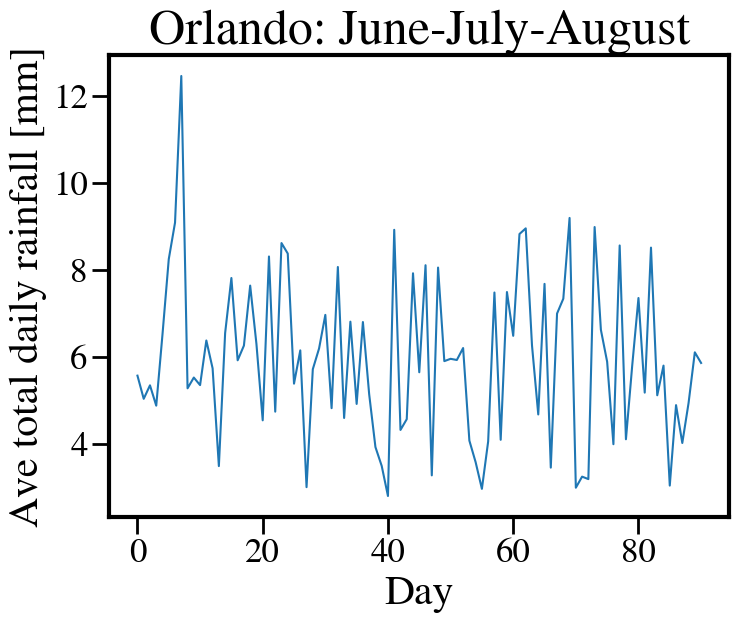

In [16]:
plt.plot(np.arange(91), np.nansum(precip_data_full_grid[:,lat_idx[5],lon_idx[5],:], axis=1))
plt.ylabel('Ave total daily rainfall [mm]')
plt.xlabel('Day')

plt.title("Orlando: June-July-August")

In [76]:
np.shape(precip_data_full_grid)

(91, 1597, 2345, 8)

In [99]:
2*np.pi / 6

1.0471975511965976

In [68]:
def diurnal_cosine(t, amp, per,phase):
    return amp * np.cos(per*t + phase)

In [69]:
popt, pcov = scipy.optimize.curve_fit(diurnal_cosine, np.arange(0,n*dt,dt), np.ravel(precip_data_full_grid[:,lat_idx[5],lon_idx[5],:]),
                                     p0=[5, 1., 5])

In [70]:
popt

array([-0.04655253,  0.99749615,  9.15897886])

In [78]:
((popt[1] / (2 * np.pi)) * 24) - 6 + 24 - 5 - 12

4.810154621694728

Text(0.5, 0, 'Frequency')

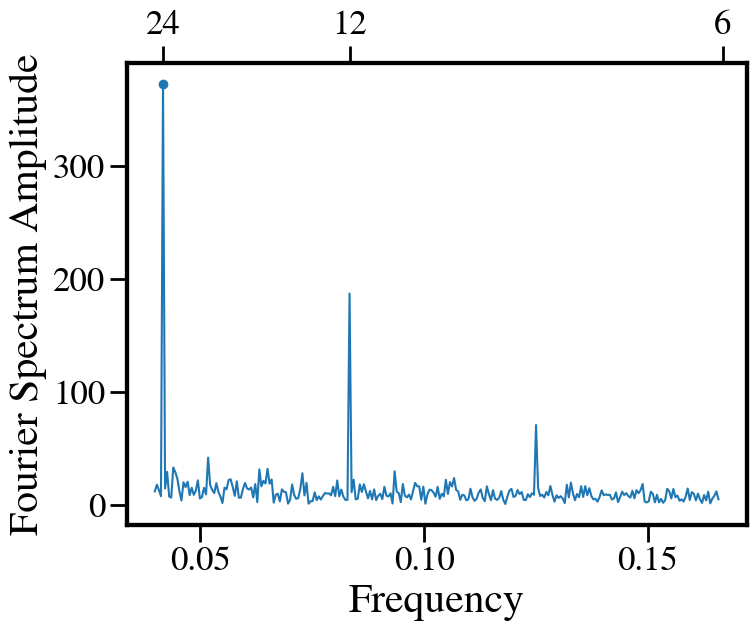

In [28]:
fig, ax = plt.subplots()
ax2 = ax.twiny()
#ax2.set_xticks(ax.get_xticks())

ax.plot(frequencies[freq_lims[0]:freq_lims[1]], signal)

ax.scatter(frequencies[idx],np.abs(fft_result[idx]))


ax2.set_xbound(ax.get_xbound())
ax2.set_xticks([1/6, 1/12, 1/24])
ax2.set_xticklabels(["6", '12', '24'])

ax.set_ylabel('Fourier Spectrum Amplitude')
ax.set_xlabel('Frequency')

(0.0, 80.0)

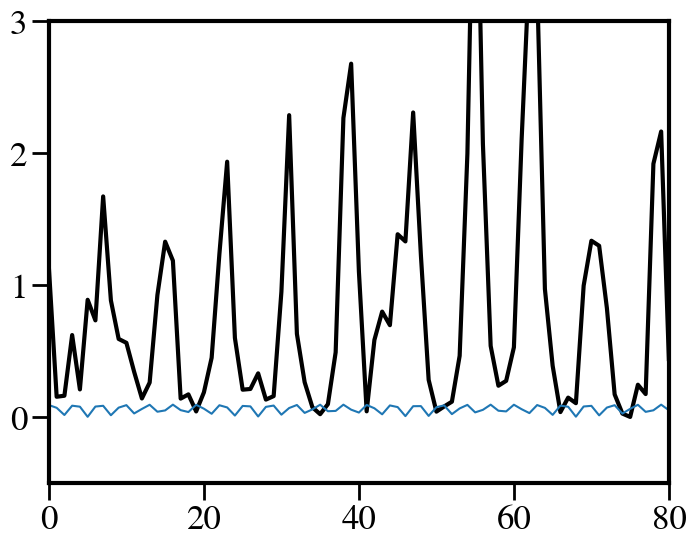

In [96]:
plt.plot(time_range, unraveled, color='black', lw=3)
#plt.plot(time_range, np.abs(2 * np.cos((2*np.pi/24.)*time_range + phase)), lw=2)
#plt.plot(time_range, np.abs(2 * np.cos((2*np.pi/12.)*time_range + phase12)))
plt.plot(time_range, 2*np.abs(diurnal_cosine(time_range, *popt)))


plt.ylim([-0.5, 3])
plt.xlim([0,8*10])

In [51]:
@numba.jit
def fft_by_grid_point(precip_data):
    shape = np.shape(precip_data)
    lat, lon = shape[1], shape[2]

    peak_time = np.zeros_like(precip_data[0,:,:,0])
    ph = np.zeros_like(precip_data[0,:,:,0])
    amp = np.zeros_like(precip_data[0,:,:,0])
    dt = 3 #duration / time intervals of precipitation data
    n = len(np.ravel(precip_data[:,0,0,:]))
    frequencies = np.fft.fftfreq(n, dt)
    
    for la in range(lat):
        for lo in range(lon):
            unraveled = np.ravel(precip_data[:,la,lo,:])
            fft_result = np.fft.fft(unraveled)
            # Find the index of the frequency closest to 24 hour period
            target_frequency = 1. / 24.
            idx = np.argmin(np.abs(frequencies - target_frequency))

            #tt = (24 * np.arctan(-1*fft_result[idx].imag/fft_result[idx].real)%24) - 6.

            # Get the amplitude and phase at this frequency
            amplitude = np.abs(fft_result[idx])
            phase = np.angle(fft_result[idx])

            # Calculate the time of peak precipitation within a 24-hour period
            # Phase shift (in hours) = (phase / (2 * pi)) * 24
            tt = ((phase / (2 * np.pi)) * 24) 
            
            if tt < 0:
                tt += 24
            peak_time[la,lo] = tt
            ph[la,lo] = phase
            amp[la,lo] = amplitude

    
    return peak_time, ph, amp

In [52]:
print('Fourier Analysis')
start = datetime.datetime.now()
peak_time,phase, amplitude = fft_by_grid_point(precip_data_full_grid)
end=datetime.datetime.now()
print(f'    Finish time: {(end-start).total_seconds()}s')

Fourier Analysis
    Finish time: 26.935765s


In [19]:
#random CONUS dataset to get lat/lon
ds = xr.open_dataset('/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2017/2017147.15.nc')

{230.0: ([<matplotlib.lines.Line2D at 0x1491f13f1b40>], []),
 240.0: ([<matplotlib.lines.Line2D at 0x1491f13f1db0>], []),
 250.0: ([<matplotlib.lines.Line2D at 0x1491f13f2050>],
  [Text(1084999.9999999998, -49999.999999999985, '110°W')]),
 260.0: ([<matplotlib.lines.Line2D at 0x1491f13f22f0>],
  [Text(2174999.9999999995, -49999.999999999985, '100°W')]),
 270.0: ([<matplotlib.lines.Line2D at 0x1491f13f2590>],
  [Text(3264999.9999999995, -49999.999999999985, '90°W')]),
 280.0: ([<matplotlib.lines.Line2D at 0x1491f13f2830>],
  [Text(4364999.999999999, -49999.999999999985, '80°W')]),
 290.0: ([<matplotlib.lines.Line2D at 0x1491f13f2ad0>], []),
 300.0: ([<matplotlib.lines.Line2D at 0x1491f13f2d70>], [])}

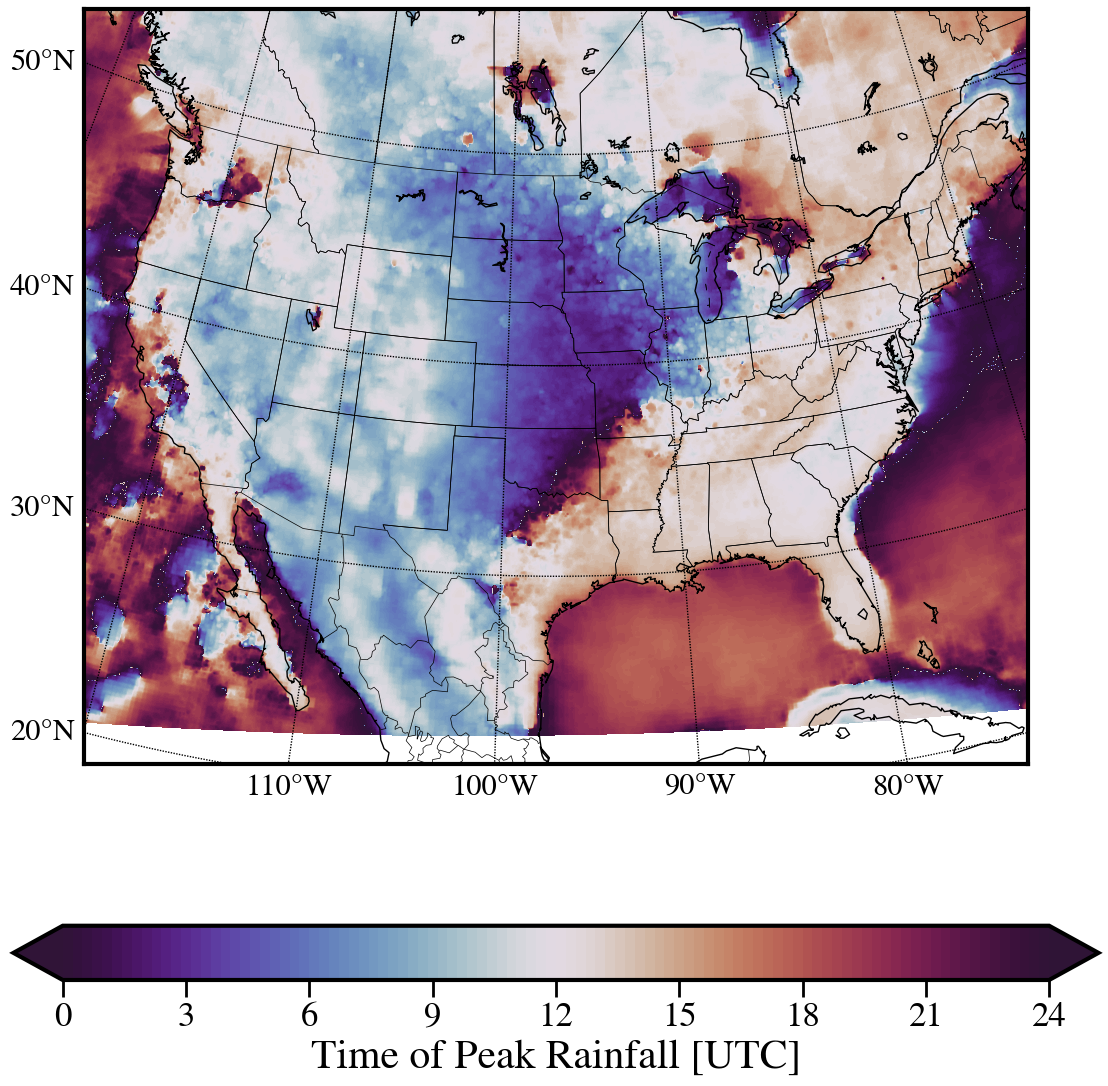

In [53]:
fig, axes = plt.subplots(1,1, figsize=(14,14))

lats, lons = ds.latitude.data, ds.longitude.data
m = Basemap(projection='lcc',lon_0=-97,lat_0=39,width=5e6,height=4e6, resolution='l')
xx, yy = m(lons,lats) #note to self, x=lons y=lats

levels = np.linspace(0,24, 101)

cs = m.contourf(xx,yy,peak_time,extend='both',ax=axes,levels=levels,cmap='twilight_shifted')

cbar=plt.colorbar(cs, orientation='horizontal')
cbar.set_label("Time of Peak Rainfall [UTC]")
cbar.set_ticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

In [39]:
lats, lons = ds.latitude.data, ds.longitude.data

nx, ny = np.shape(lats)[1], np.shape(lats)[0]

In [54]:
@numba.jit
def convert_peak_time(peak_time_arr, longitude):
    converted_peak_times = np.zeros_like(peak_time_arr)
    this_timezone_arr = np.zeros_like(peak_time_arr)
    for la in range(ny):
        for lo in range(nx):
            #a = np.abs(lats[la,lo]-all_station_lats) + np.abs(lons[la,lo]-all_station_lons)
            #station_df_idx = a.argmin()
            #print(station_df_idx)
            #this_timezone = timezones[station_df_idx]

            this_timezone = (longitude[la,lo]-360.) / 15.

            ptime = peak_time_arr[la,lo] + this_timezone
            if ptime < 0:
                ptime += 24
            #if ptime > 24:
            #    ptime -= 24
            converted_peak_times[la, lo] = ptime #+ (-ptime % 3.)
            this_timezone_arr[la,lo] = this_timezone
            
    return converted_peak_times, this_timezone_arr

In [55]:
start = datetime.datetime.now()
converted_peak_times,utc_to_lst =  convert_peak_time(peak_time, lons)
end=datetime.datetime.now()
print(f'    Finish time: {(end-start).total_seconds()}s')

    Finish time: 0.16138s


{230.0: ([<matplotlib.lines.Line2D at 0x1491f07b2170>], []),
 240.0: ([<matplotlib.lines.Line2D at 0x1491f07b23e0>], []),
 250.0: ([<matplotlib.lines.Line2D at 0x1491f07b2680>],
  [Text(1084999.9999999998, -49999.999999999985, '110°W')]),
 260.0: ([<matplotlib.lines.Line2D at 0x1491f07b2920>],
  [Text(2174999.9999999995, -49999.999999999985, '100°W')]),
 270.0: ([<matplotlib.lines.Line2D at 0x1491f07b2bc0>],
  [Text(3264999.9999999995, -49999.999999999985, '90°W')]),
 280.0: ([<matplotlib.lines.Line2D at 0x1491f07b2e60>],
  [Text(4364999.999999999, -49999.999999999985, '80°W')]),
 290.0: ([<matplotlib.lines.Line2D at 0x1491f07b3100>], []),
 300.0: ([<matplotlib.lines.Line2D at 0x1491f07b33a0>], [])}

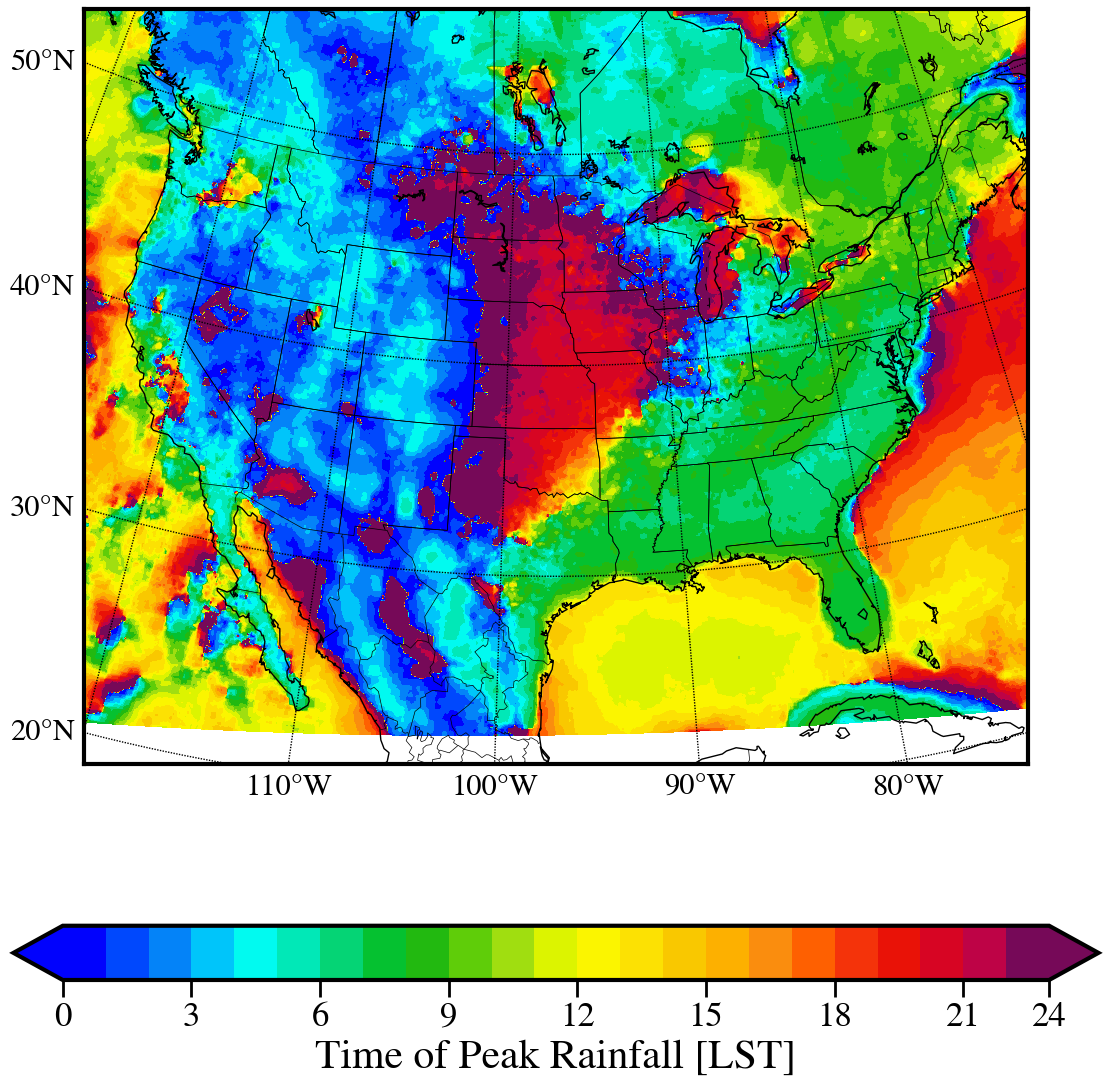

In [56]:
fig, axes = plt.subplots(1,1, figsize=(14,14))

clevs_colors = ['#0102fd', '#0048fd', '#0483f8', '#00c5fa', '#01faf0', '#01e8b7', '#05d475', '#05c130', 
         '#22b910', '#5fcd09', '#a0de10','#dcf400', '#fbf500', '#fce103', '#f9c800', '#fdb000',
        '#fa8d0e', '#fe6001', '#f4330a', '#e91207', '#d70523', '#be0346', '#760958', '#550191']

lats, lons = ds.latitude.data, ds.longitude.data
m = Basemap(projection='lcc',lon_0=-97,lat_0=39,width=5e6,height=4e6, resolution='l')
xx, yy = m(lons,lats) #note to self, x=lons y=lats

levels = np.arange(0,24,1)

cs = m.contourf(xx,yy,converted_peak_times,extend='both',ax=axes,levels=levels,cmap=None,colors=clevs_colors)

cbar=plt.colorbar(cs, orientation='horizontal')
cbar.set_label("Time of Peak Rainfall [LST]"
              )
cbar.set_ticks([0, 3, 6, 9, 12, 15, 18, 21,24])

m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

In [58]:
test = grib2io.open("/scratch2/STI/mdl-sti/Sidney.Lower/data/gefs/20231005/gefs19.t0z.f120")

In [60]:
test[0]

Section 0: discipline = 0 - Meteorological Products
Section 1: originatingCenter = 7 - US National Weather Service - NCEP (WMC)
Section 1: originatingSubCenter = 2 - NCEP Ensemble Products
Section 1: masterTableInfo = 2 - Version Implemented on 4 November 2003
Section 1: localTableInfo = 1 - Number of local table version used.
Section 1: significanceOfReferenceTime = 1 - Start of Forecast
Section 1: year = 2023
Section 1: month = 10
Section 1: day = 5
Section 1: hour = 0
Section 1: minute = 0
Section 1: second = 0
Section 1: refDate = 2023-10-05 00:00:00
Section 1: productionStatus = 0 - Operational Products
Section 1: typeOfData = 4 - Perturbed Forecast Products
Section 3: sourceOfGridDefinition = 0 - Specified in Code Table 3.1
Section 3: numberOfDataPoints = 1038240
Section 3: interpretationOfListOfNumbers = 0 - There is no appended list
Section 3: gridDefinitionTemplateNumber = 0 - Latitude/Longitude
Section 3: shapeOfEarth = 6 - Earth assumed spherical with radius = 6,371,229.0 m


{230.0: ([<matplotlib.lines.Line2D at 0x1546dfd4b1c0>], []),
 240.0: ([<matplotlib.lines.Line2D at 0x1546dfd4b430>], []),
 250.0: ([<matplotlib.lines.Line2D at 0x1546dfd4b6d0>],
  [Text(1084999.9999999998, -49999.999999999985, '110°W')]),
 260.0: ([<matplotlib.lines.Line2D at 0x1546dfd4b970>],
  [Text(2174999.9999999995, -49999.999999999985, '100°W')]),
 270.0: ([<matplotlib.lines.Line2D at 0x1546dfd4bc10>],
  [Text(3264999.9999999995, -49999.999999999985, '90°W')]),
 280.0: ([<matplotlib.lines.Line2D at 0x1546dfd4beb0>],
  [Text(4364999.999999999, -49999.999999999985, '80°W')]),
 290.0: ([<matplotlib.lines.Line2D at 0x1546dfd8c190>], []),
 300.0: ([<matplotlib.lines.Line2D at 0x1546dfd8c430>], [])}

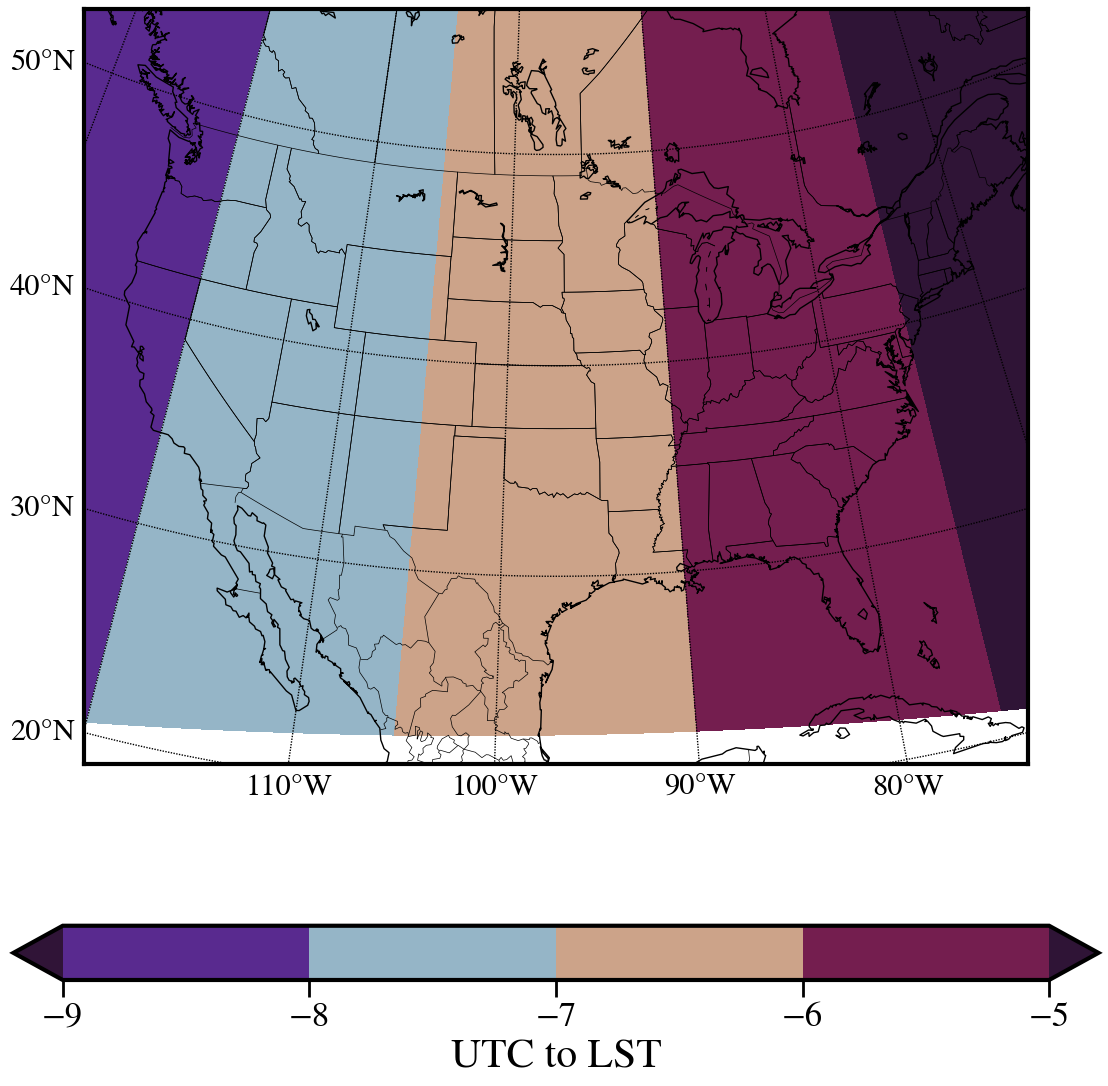

In [65]:
fig, axes = plt.subplots(1,1, figsize=(14,14))

lats, lons = ds.latitude.data, ds.longitude.data
m = Basemap(projection='lcc',lon_0=-97,lat_0=39,width=5e6,height=4e6, resolution='l')
xx, yy = m(lons,lats) #note to self, x=lons y=lats

levels = np.arange(-9,-4)

cs = m.contourf(xx,yy,utc_to_lst,extend='both',ax=axes,levels=levels,cmap='twilight_shifted')

cbar=plt.colorbar(cs, orientation='horizontal')
cbar.set_label("UTC to LST")
#cbar.set_ticks([0, 3, 6, 9, 12, 15, 18, 21,24])

m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

# Verify 

In [57]:
import re
natsort = lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split('(\d+)', s)]

files = sorted(glob(f'/scratch2/STI/mdl-sti/Sidney.Lower/diurnal_cycle_data/precip_climo_diurnal_cycle_*.co.2p5.nc'), key=natsort)

dc = xr.open_mfdataset(files,concat_dim=[pd.Index(np.arange(1,13), name="month")],combine="nested")
lats, lons = dc.latitude.data, dc.longitude.data


In [58]:
dc 

<xarray.Dataset> Size: 389MB
Dimensions:             (month: 12, y: 1597, x: 2345)
Coordinates:
    latitude            (y, x) float32 15MB dask.array<chunksize=(1597, 2345), meta=np.ndarray>
    longitude           (y, x) float32 15MB dask.array<chunksize=(1597, 2345), meta=np.ndarray>
  * month               (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: y, x
Data variables:
    peak_rainfall_time  (month, y, x) float32 180MB dask.array<chunksize=(1, 1597, 2345), meta=np.ndarray>
    amplitude           (month, y, x) float32 180MB dask.array<chunksize=(1, 1597, 2345), meta=np.ndarray>

In [59]:
peak_time = dc.peak_rainfall_time.data.compute()

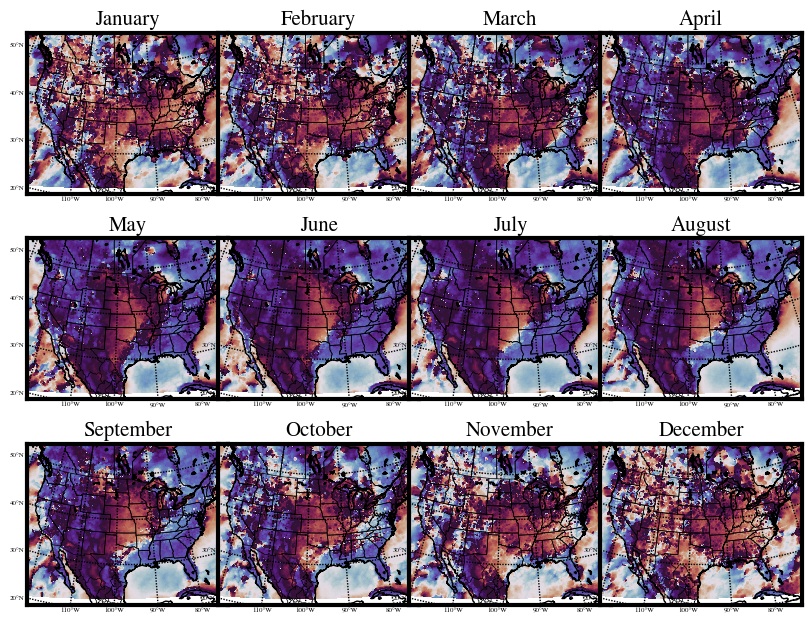

In [60]:
fig, axes = plt.subplot_mosaic('ABCD;EFGH;IJKL', figsize=(10,8))
plt.subplots_adjust(hspace=0., wspace=-0.05)

m = Basemap(projection='lcc',lon_0=-97,lat_0=39,width=5e6,height=4e6, resolution='l')
xx, yy = m(lons,lats) #note to self, x=lons y=lats

levels = np.linspace(0,24, 101)
for month, ax in enumerate(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']):
    m.contourf(xx,yy,peak_time[month],extend='both',ax=axes[ax],levels=levels,cmap='twilight_shifted')
    axes[ax].set_title(f"{datetime.datetime(year=2023, month=month+1, day=1).strftime('%B')}", fontsize=15)

    m.drawcoastlines(ax=axes[ax])
    m.drawcountries(ax=axes[ax])
    m.drawstates(ax=axes[ax])
    m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=5,ax=axes[ax])
    m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=5,ax=axes[ax])

#axes.set_title(f"")

# Calibrating diurnal cycle penalty

In [7]:
month = 7
sl_model = 'limit_water_v4'

In [6]:
conus_gp = xr.open_dataset('/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/expanded_conus_grid_sample_points.zarr')

/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [8]:
sl = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/{sl_model}/blend.supplemental_locations_{month}.co.2p5.nc')

In [9]:
lat_arr = sl.latitude.data
lon_arr = sl.longitude.data

xlocs = sl.xlocations.data
ylocs = sl.ylocations.data

In [10]:
dc = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/diurnal_cycle_data/precip_climo_diurnal_cycle_{month}.co.2p5.nc')

In [13]:
peak_time = dc.peak_rainfall_time.data
amplitude = dc.amplitude.data

In [12]:
lat_idx = conus_gp.latitude_idx.data
lon_idx = conus_gp.longitude_idx.data

How to construct the diurnal cycle penalty? We want the smallest penalty for SLs with the most similar peak time **and** signal amplitude. If we only compare peak times, we ignore the fact that some locations have a very loose diurnal cycle to begin with (i.e., their rainfall does not really have a daily pattern).

One proposal:

$$ \Delta \mathrm{diurnal\;cycle} = \Delta \mathrm{peak\;time} * \Delta \mathrm{amplitude} $$ where

$$ \Delta \mathrm{peak\;time} = | \mathrm{peak\;time_{gp}} - \mathrm{peak\;time_{sl}} | $$
$$ \Delta \mathrm{amplitude} = | \mathrm{amplitude_{gp}} - \mathrm{amplitude_{sl}} | $$

One limitation is that the penalty values can be much much larger than the penalties for climo and terrain so we need to them somehow.
**AND** we need to account for the fact that numerically the difference between 23 and 0 is large but physically, time-wise, they are not...

In [17]:
loc = 10
pt = peak_time[lat_idx[loc], lon_idx[loc]]
amp = amplitude[lat_idx[loc], lon_idx[loc]]
print(pt, amp)

3.76363 798.5159


In [22]:
x_sl = xlocs[:,lat_idx[loc], lon_idx[loc]].astype(int) - 1
y_sl = ylocs[:,lat_idx[loc], lon_idx[loc]].astype(int)-1

pt_sls = peak_time[y_sl, x_sl]
amp_sls = amplitude[y_sl, x_sl]

(array([21., 15.,  2.,  0.,  0.,  0.,  0.,  0.,  0., 12.]),
 array([1.09945247e-02, 2.40197158e+00, 4.79294872e+00, 7.18392563e+00,
        9.57490253e+00, 1.19658794e+01, 1.43568563e+01, 1.67478333e+01,
        1.91388111e+01, 2.15297871e+01, 2.39207649e+01]),
 <BarContainer object of 10 artists>)

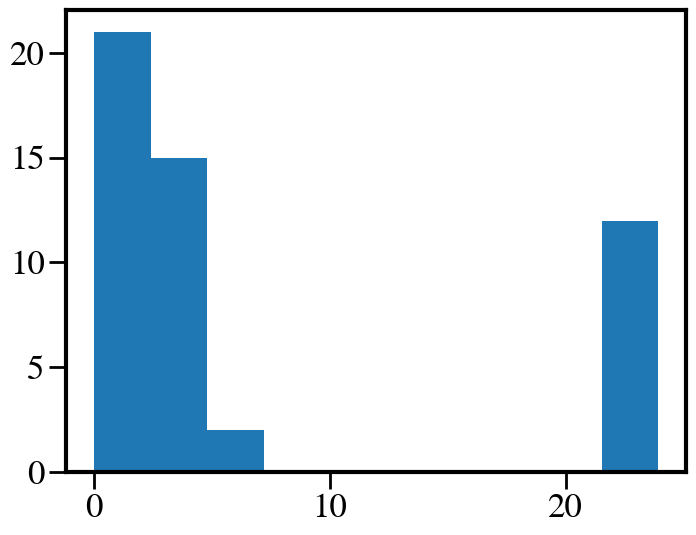

In [25]:
plt.hist(pt_sls)

What if we compare phase angles instead of phase --> time?

Rerun code in above section to get phase and amplitude

In [53]:
loc = 3
ph = phase[lat_idx[loc], lon_idx[loc]]
amp = amplitude[lat_idx[loc], lon_idx[loc]]
print(ph, amp)

0.4049094 158.52095


In [54]:
x_sl = xlocs[:,lat_idx[loc], lon_idx[loc]].astype(int) - 1
y_sl = ylocs[:,lat_idx[loc], lon_idx[loc]].astype(int)-1

ph_sls = phase[y_sl, x_sl]
amp_sls = amplitude[y_sl, x_sl]

(array([ 1.,  1.,  1.,  9., 23.,  9.,  4.,  1.,  0.,  1.]),
 array([-1.77659035, -1.34119821, -0.90580606, -0.47041392, -0.03502178,
         0.40037036,  0.8357625 ,  1.27115464,  1.70654678,  2.14193892,
         2.57733107]),
 <BarContainer object of 10 artists>)

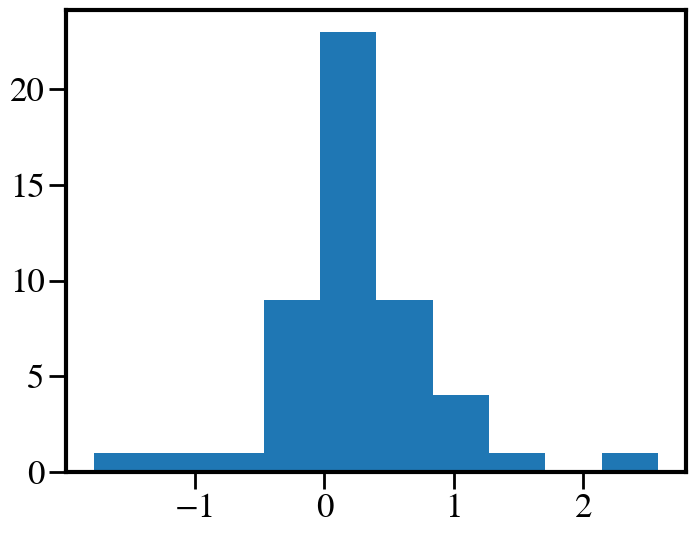

In [55]:
plt.hist(ph_sls)

Text(0.5, 0, 'Fourier Phase')

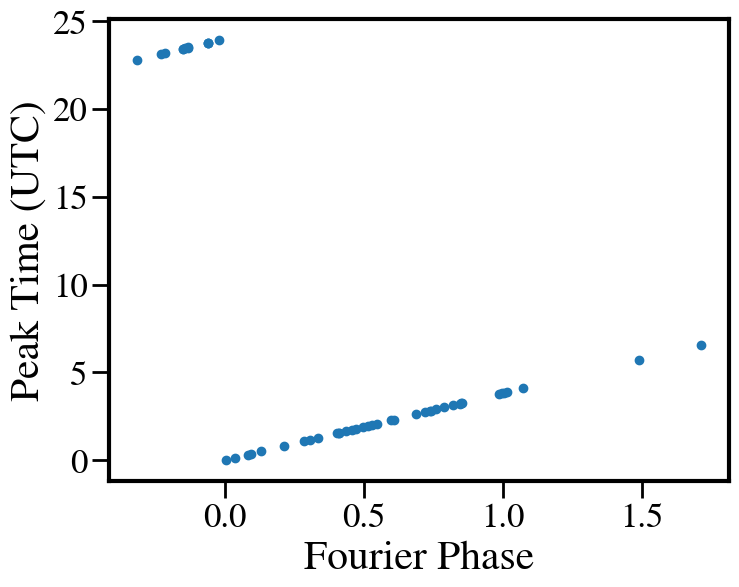

In [38]:
plt.scatter(ph_sls, pt_sls)
plt.ylabel('Peak Time (UTC)')
plt.xlabel('Fourier Phase')

In [56]:
ph_diff = ph - ph_sls
amp_diff = (amp - amp_sls)/amp

In [57]:
amp

158.52095

In [58]:
amp_diff

array([ 0.        , -0.28878886,  0.62448174, -0.3464174 ,  0.38539612,
       -1.0272942 , -0.38545865, -1.6963217 , -0.9811228 , -1.0356598 ,
       -1.2727202 , -1.2552515 ,  0.39826006, -2.1088054 ,  0.55425376,
       -1.4914508 , -3.1866994 , -1.8606725 ,  0.67068046, -1.1161107 ,
        0.14409679, -1.1821342 , -3.831096  , -3.4015036 , -1.7062597 ,
       -1.4354244 ,  0.17628416,  0.6655527 , -1.1367931 , -1.5524305 ,
       -0.7494807 , -1.5322433 , -1.674747  , -1.5657569 , -0.8298592 ,
       -2.601674  ,  0.06185779,  0.8397212 ,  0.78598887,  0.3028042 ,
        0.41779578, -1.9605659 ,  0.5968741 ,  0.9555963 , -3.4761107 ,
       -1.9038273 , -0.43487614,  0.08588456, -0.91035485,  0.501097  ],
      dtype=float32)

(array([ 1.,  2.,  1.,  3.,  5., 13., 16.,  4.,  3.,  2.]),
 array([-2.07595825, -1.7590481 , -1.44213796, -1.12522793, -0.80831778,
        -0.49140763, -0.17449751,  0.14241262,  0.45932275,  0.77623284,
         1.09314299]),
 <BarContainer object of 10 artists>)

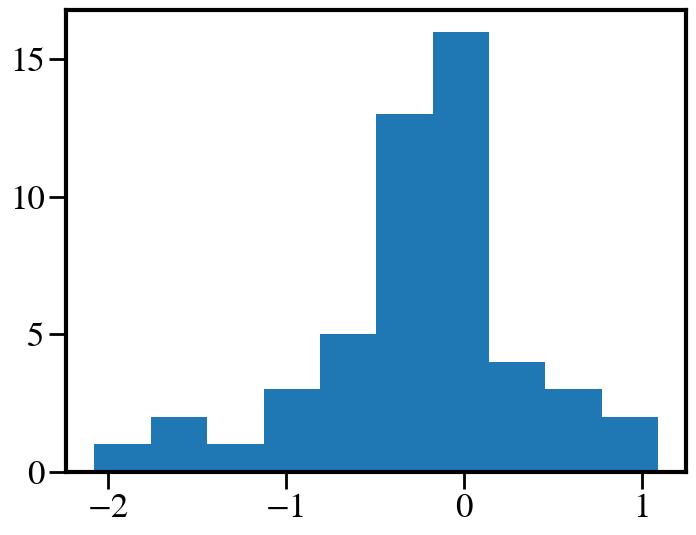

In [59]:
plt.hist(ph_diff*amp_diff)

In [61]:
rand_locs = np.random.randint(0,499, size=9)

Text(0.25, 0, 'Diurnal Penalty = $\\Delta \\phi \\cdot \\Delta A$')

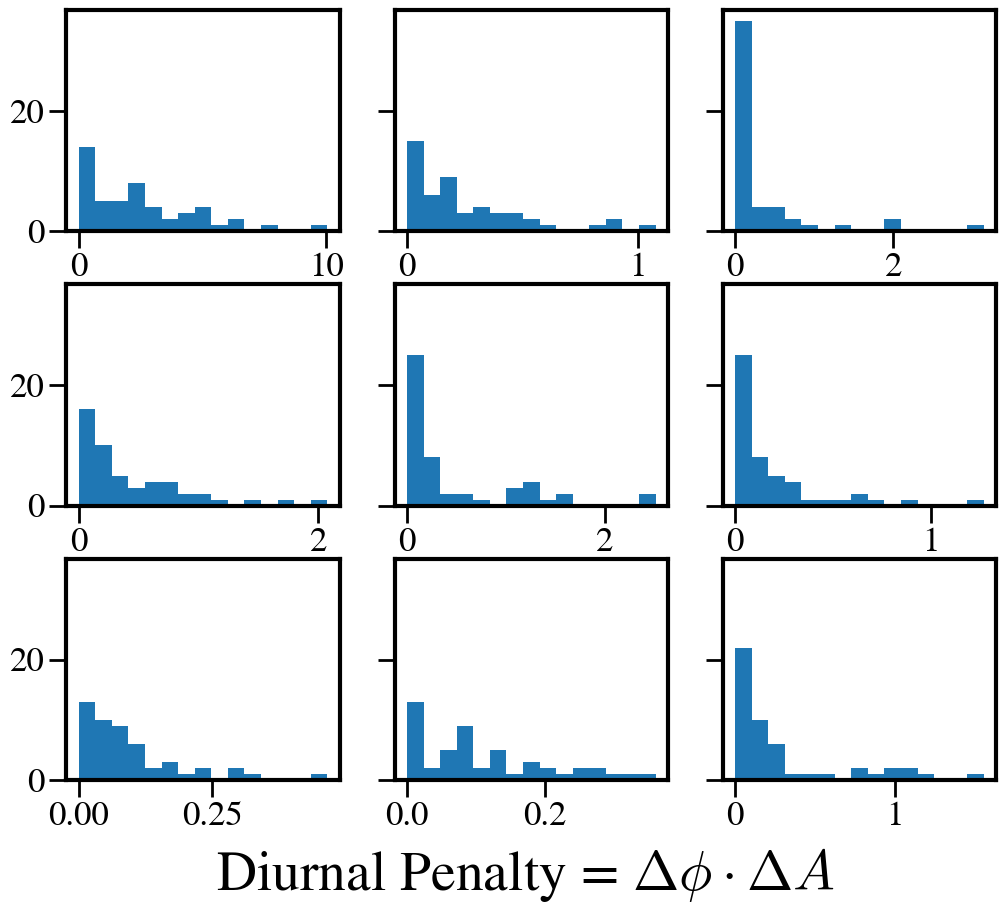

In [101]:
fig, ax = plt.subplots(3,3, sharey=True, figsize=(12, 10))
plt.subplots_adjust(hspace=0.24)

nbins=15

for i in range(3):
    for j in range(3):
        loc = 3*i + j
        x_sl = xlocs[:,lat_idx[loc], lon_idx[loc]].astype(int) - 1
        y_sl = ylocs[:,lat_idx[loc], lon_idx[loc]].astype(int)-1
        ph_sls = phase[y_sl, x_sl]
        amp_sls = amplitude[y_sl, x_sl]

        ph_diff = np.sqrt((ph_sls[0] - ph_sls)**2)
        amp_diff = np.abs(amp_sls[0] - amp_sls)/amp_sls[0]
        
        ax[i,j].hist(ph_diff*amp_diff, bins=nbins)

fig.text(x=0.25, y=0, s='Diurnal Penalty = $\Delta \phi \cdot \Delta A$', fontdict={'fontsize': 40})

In [68]:
ph_diff*amp_diff

array([0.0000000e+00, 1.3512204e+02, 4.0050163e+01, 1.4231981e+02,
       3.4973560e+01, 2.4842496e+02, 6.9842537e+01, 6.7065475e+01,
       9.7854370e+02, 4.8967938e+02, 4.1011921e+01, 3.2352741e+01,
       1.0921429e+03, 7.3661873e+01, 2.2695692e+02, 1.5063640e+02,
       1.4178252e+02, 6.4697365e+01, 2.6177777e+02, 7.2769539e+01,
       1.9244520e+01, 6.7605518e+02, 3.3233594e+02, 3.1074183e+01,
       1.9052393e+02, 1.9361620e+02, 7.2318802e+01, 1.8179216e+02,
       1.7424976e+00, 1.6723834e+02, 9.2745618e+02, 1.2504430e+03,
       3.1490979e+02, 1.1567562e+03, 1.7487312e+03, 2.9277411e+02,
       2.6577984e+01, 3.9707181e+02, 9.0190384e+01, 9.2633282e+02,
       1.1779274e+03, 4.0195389e+01, 8.7064941e+01, 2.9688629e+01,
       9.8286858e+01, 4.6222015e+01, 3.2395865e+02, 1.3879768e+03,
       1.2362295e+02, 2.5098175e+01], dtype=float32)

$$ \Delta \mathrm{diurnal\;cycle} = \Delta \mathrm{phase} \cdot \Delta \mathrm{amplitude} $$ where

$$ \Delta \mathrm{phase} = | \mathrm{phase_{gp}} - \mathrm{phase_{sl}} | $$
$$ \Delta \mathrm{amplitude} = \frac{| \mathrm{amplitude_{gp}} - \mathrm{amplitude_{sl}} |}{\mathrm{amplitude_{gp}}} $$

In [96]:
t = xr.open_dataset('/scratch2/STI/mdl-sti/Sidney.Lower/diurnal_cycle_data/precip_climo_diurnal_cycle_with_phase_7.co.2p5.nc')

In [97]:
t

<xarray.Dataset> Size: 75MB
Dimensions:             (y: 1597, x: 2345)
Coordinates:
    latitude            (y, x) float32 15MB ...
    longitude           (y, x) float32 15MB ...
Dimensions without coordinates: y, x
Data variables:
    phase               (y, x) float32 15MB ...
    peak_rainfall_time  (y, x) float32 15MB ...
    amplitude           (y, x) float32 15MB ...

In [2]:
sl = xr.open_dataset('/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/diurnal_cycle/blend.supplemental_locations_7.co.2p5.nc')

In [4]:
locations = xr.open_dataset('/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/expanded_conus_grid_sample_points.zarr')

/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [5]:
lat_idx = locations.latitude_idx.data
lon_idx = locations.longitude_idx.data

In [3]:
sl

<xarray.Dataset> Size: 4GB
Dimensions:        (ya: 1597, xa: 2345, xsupp: 50)
Coordinates:
    latitude       (ya, xa) float32 15MB ...
    longitude      (ya, xa) float32 15MB ...
Dimensions without coordinates: ya, xa, xsupp
Data variables:
    xlocations     (xsupp, ya, xa) float64 1GB ...
    ylocations     (xsupp, ya, xa) float64 1GB ...
    nsupplemental  (ya, xa) float32 15MB ...
    differences    (xsupp, ya, xa) float32 749MB ...
Attributes:
    domain:   co
    month:    7

In [6]:
plt.plot(np.arange(50))

array([0.00000000e+00, 1.89963555e-06, 6.96336792e-06, 1.82391741e-05,
       2.46895888e-05, 3.19378523e-05, 3.32575983e-05, 4.51607593e-05,
       7.41043114e-05, 9.06400601e-05, 1.10422770e-04, 1.11821697e-04,
       2.24104588e-04, 2.33785409e-04, 2.36555599e-04, 2.43285162e-04,
       2.68328993e-04, 2.91661127e-04, 3.29242874e-04, 3.62718507e-04,
       5.45251591e-04, 6.74396229e-04, 8.21935013e-04, 9.73405608e-04,
       1.19491236e-03, 1.54736976e-03, 1.56081608e-03, 1.64862571e-03,
       1.86433760e-03, 2.70229066e-03, 3.16871307e-03, 3.63992644e-03,
       3.80935543e-03, 3.82208358e-03, 5.47439652e-03, 5.80765307e-03,
       7.91617297e-03, 8.05668999e-03, 1.04709435e-02, 1.22061493e-02,
       1.70877185e-02, 8.18395093e-02, 9.21167806e-02, 1.36533916e-01,
       1.47076771e-01, 1.92648858e-01, 2.39257574e-01, 2.66737849e-01,
       3.31111044e-01, 4.03743684e-01], dtype=float32)